# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Simulations-by-integrating-sample-from-GP" data-toc-modified-id="Simulations-by-integrating-sample-from-GP-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulations by integrating sample from GP</a></div><div class="lev2 toc-item"><a href="#checking-valid-gradients" data-toc-modified-id="checking-valid-gradients-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>checking valid gradients</a></div><div class="lev1 toc-item"><a href="#Simulating-SE-data-to-test-extrapolation" data-toc-modified-id="Simulating-SE-data-to-test-extrapolation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulating SE data to test extrapolation</a></div><div class="lev2 toc-item"><a href="#fit-IntegSE-gradient" data-toc-modified-id="fit-IntegSE-gradient-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>fit IntegSE gradient</a></div><div class="lev1 toc-item"><a href="#Extrapolating-behavior:-plots" data-toc-modified-id="Extrapolating-behavior:-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extrapolating behavior: plots</a></div>

In [114]:
using GaussianProcesses

using GaussianProcesses: dk_dll, predict_f, get_params

In [117]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
plt.rc("savefig", dpi=300.0)
# plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Simulations by integrating sample from GP

In [3]:
se = SEIso(0.3, 0.3)

Type: GaussianProcesses.SEIso, Params: [0.3, 0.3]


In [4]:
prior_GP = GPE(;k=se, m=MeanZero(), logNoise=1e-8)

GP Exact object:
  Dim = 0
  Number of observations = 0
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.3, 0.3]


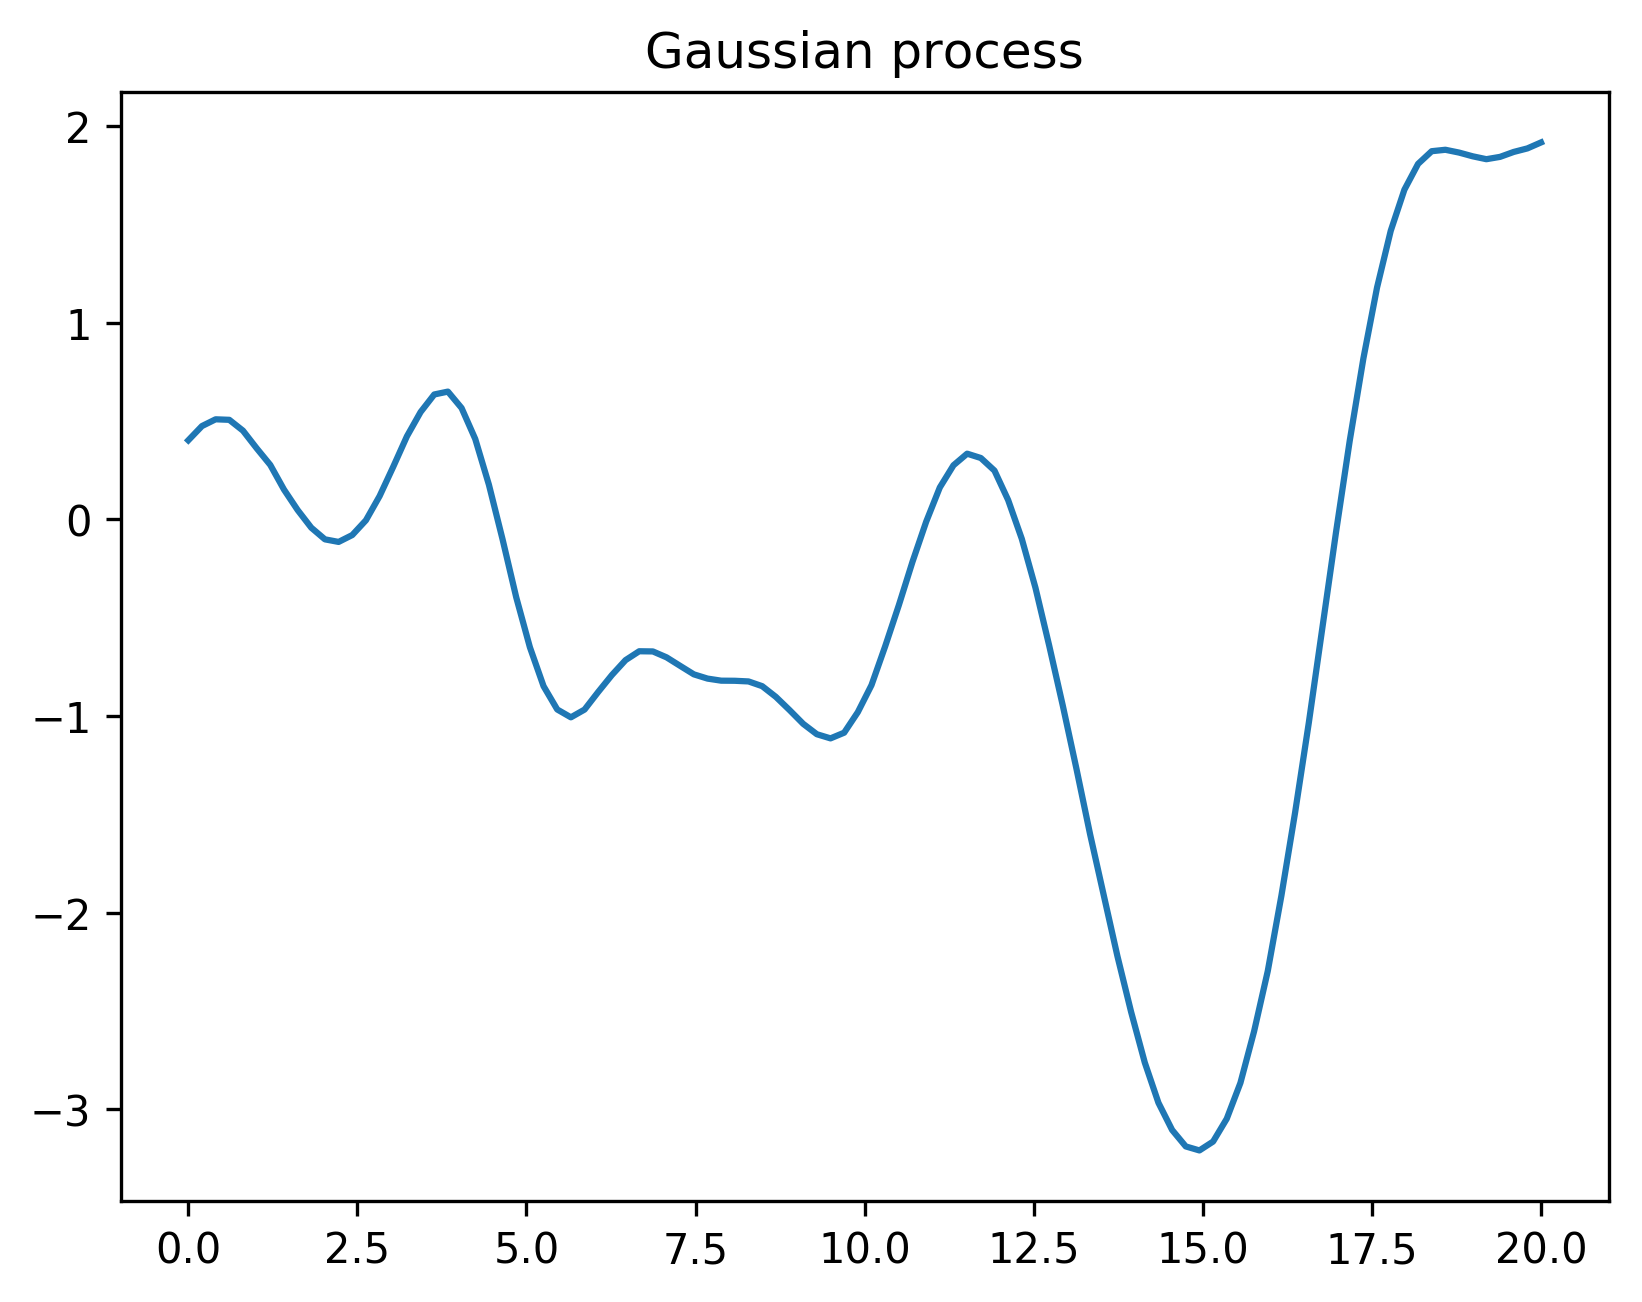

  No observation data


In [5]:
xx = linspace(0,20,100)
srand(1)
r=rand(prior_GP, xx, 1)
plt.plot(xx, r)
plt.title("Gaussian process")
;

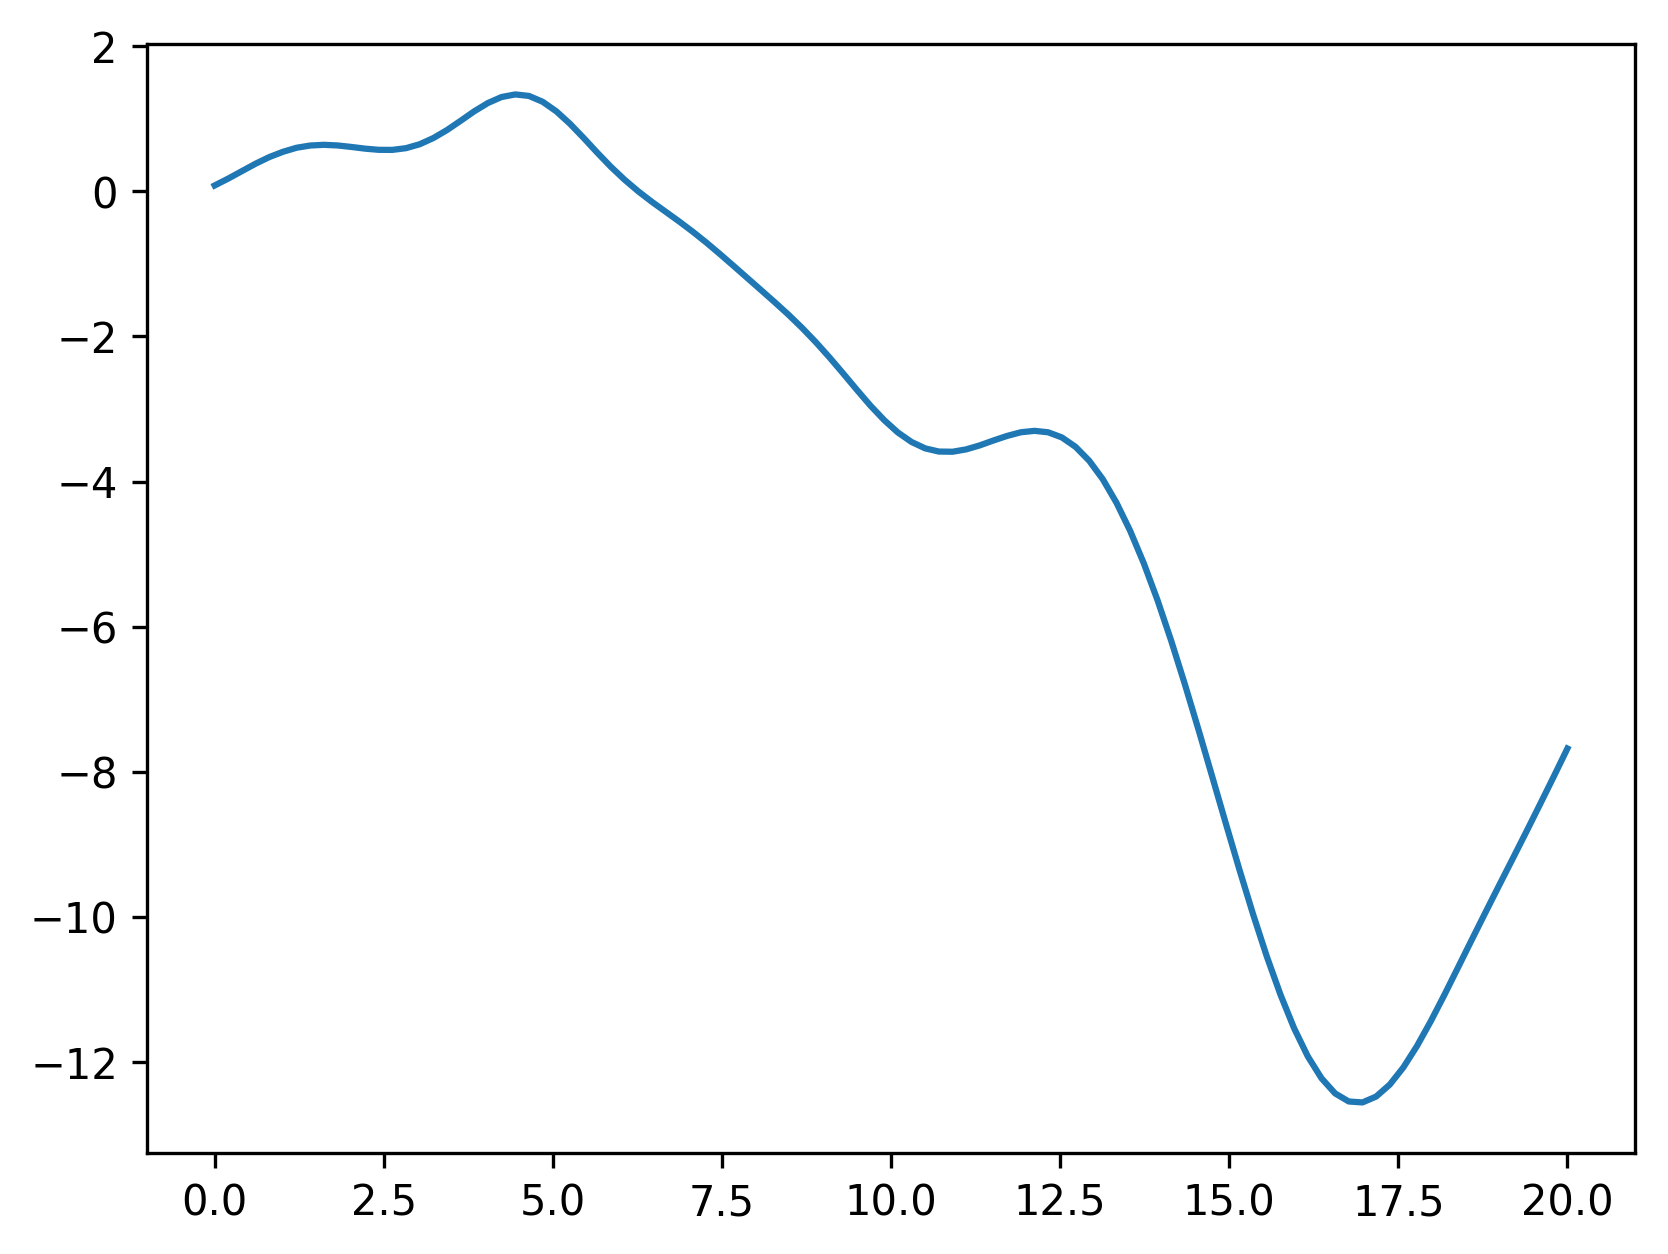

In [6]:
dx=median(diff(xx))
int_r = cumsum(r)*dx
plt.plot(xx, int_r)
;

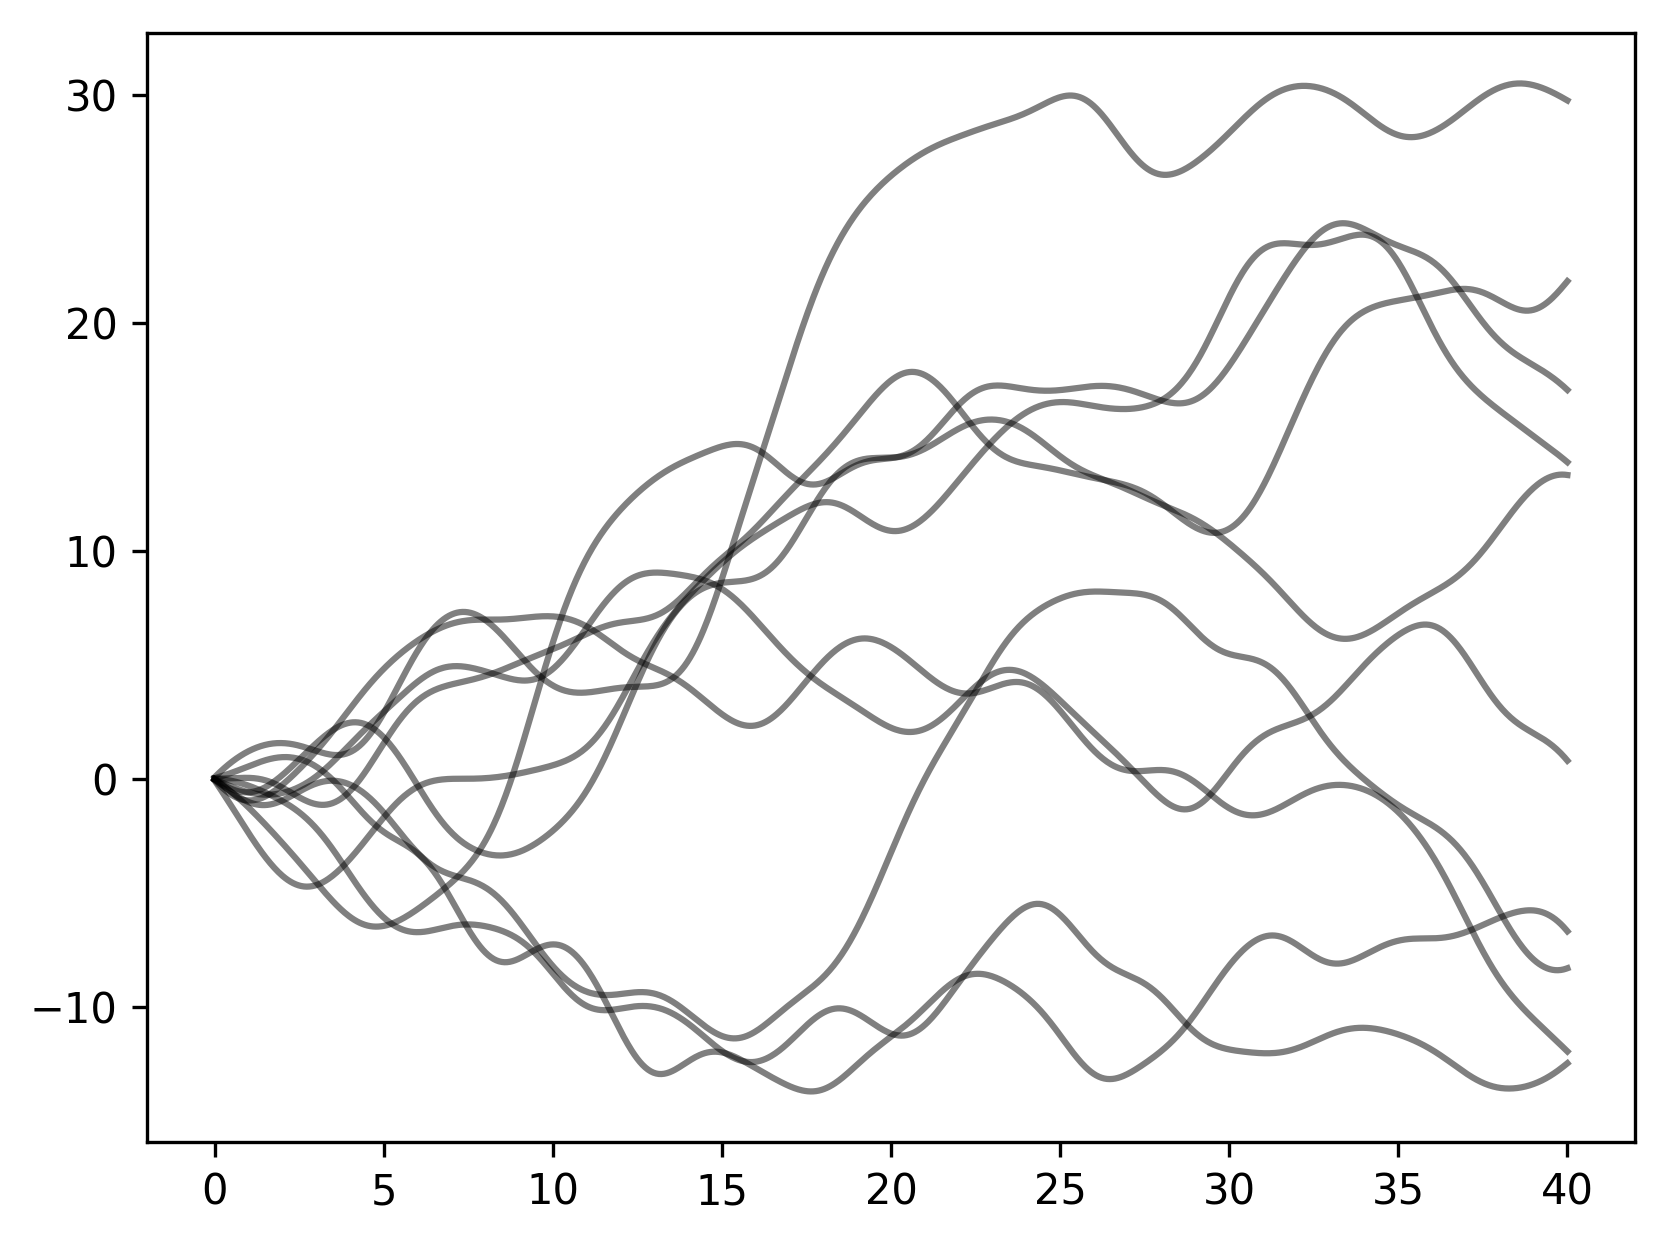

In [7]:
xx = linspace(0,40,1000)
srand(1)
for _ in 1:10
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.5)
end

In [8]:
function var_intgp(x, σ, l)
    u = x / l / √2
    2 * σ^2 * l^2 * ( u * √π  * erf(u) + exp(-u^2) - 1.0)
end

var_intgp (generic function with 1 method)

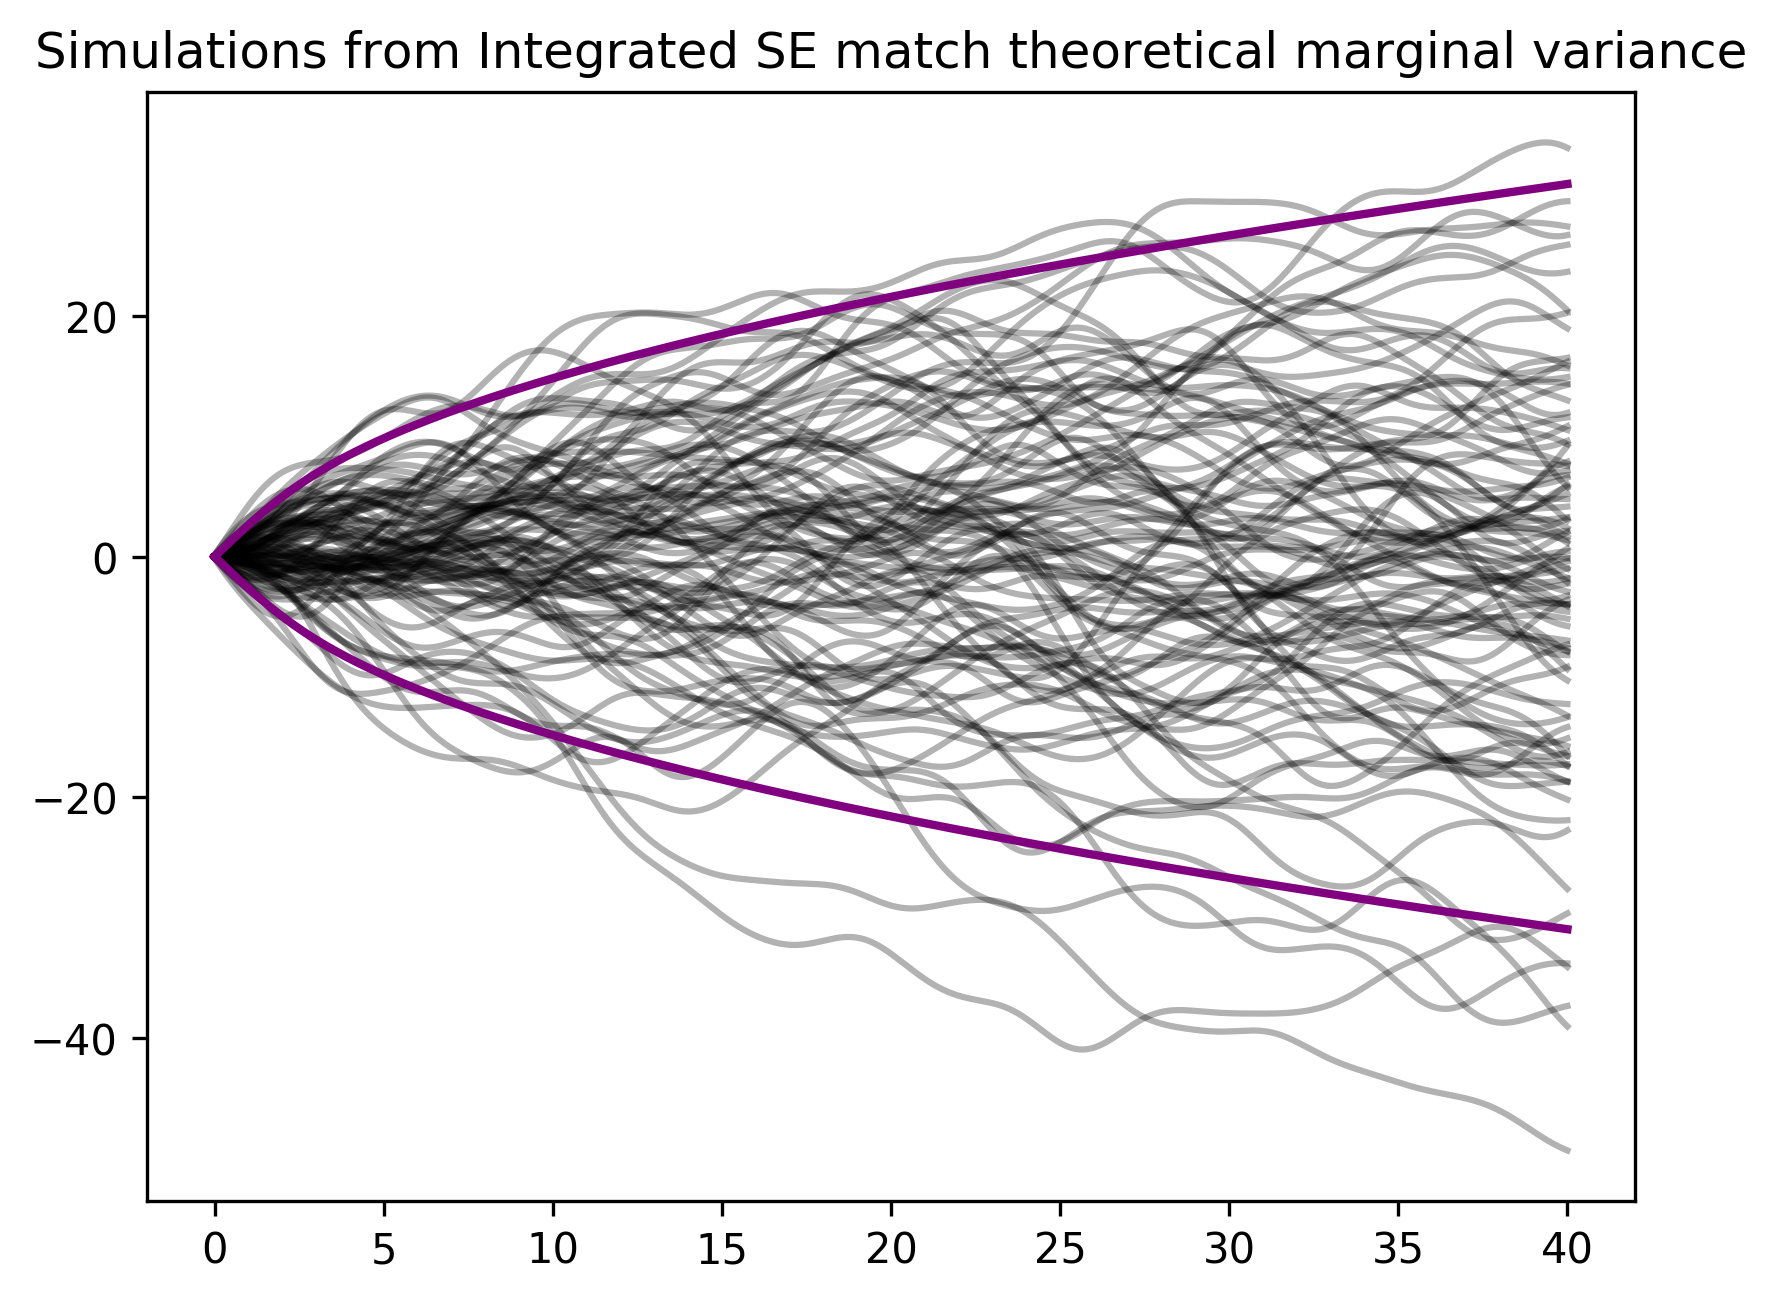

PyObject <matplotlib.text.Text object at 0x1337c2048>

In [9]:
xx = linspace(0,40,1000)
for _ in 1:100
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.3)
end
plt.plot(xx,  2*.√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.plot(xx, -2*.√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.title("Simulations from Integrated SE match theoretical marginal variance")

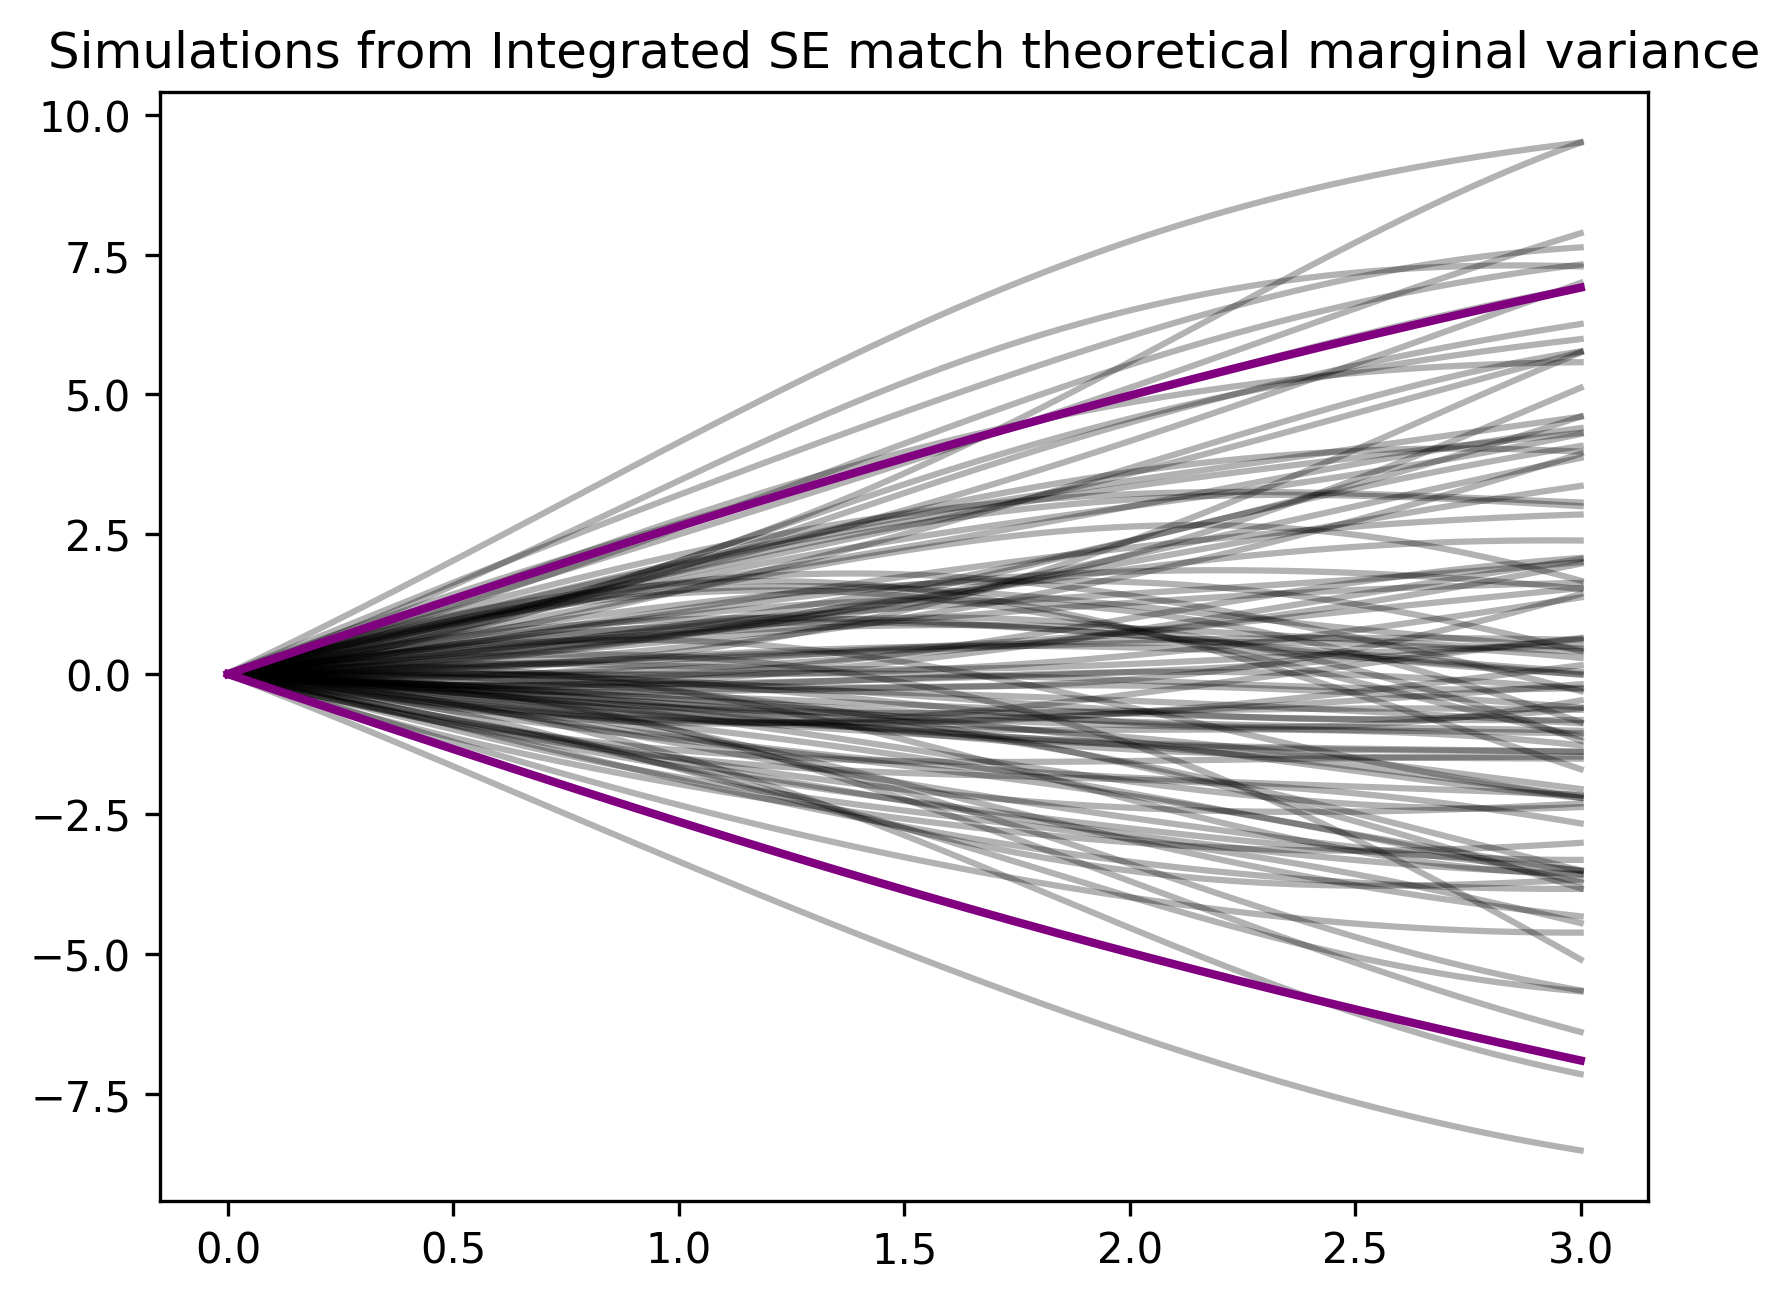

PyObject <matplotlib.text.Text object at 0x12843bba8>

In [10]:
xx = linspace(0,3,1000)
for _ in 1:100
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.3)
end
plt.plot(xx,  2*.√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.plot(xx, -2*.√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.title("Simulations from Integrated SE match theoretical marginal variance")

In [11]:
module integse
    using GaussianProcesses: SEIso
    import GaussianProcesses: cov, cov!, get_params, EmptyData, Kernel, MatF64
    import GaussianProcesses: set_params!, num_params, dKij_dθp, dk_dll
    function var_intgp(x, σ, l)
        u = x / l / √2
        2 * σ^2 * l^2 * ( u * √π  * erf(u) + exp(-u^2) - 1.0)
    end
    type IntegSE <: Kernel
        ℓ2::Float64
        σ2::Float64
        priors::Array
        IntegSE(ll::Float64, lσ::Float64) = new(exp(2*ll), exp(2*lσ), [])
    end
    IntegSE(se::SEIso) = IntegSE(get_params(se)...)

    function cov(igse::IntegSE, x₁::Float64, x₂::Float64)
        u = x₁ / √(2 * igse.ℓ2)
        v = x₂ / √(2 * igse.ℓ2)
        uv = abs(u-v)
        ku = u * erf(u) + 1/√π * exp(-u^2)
        kv = v * erf(v) + 1/√π * exp(-v^2)
        kuv = uv * erf(uv) + 1/√π * exp(-uv^2)
        return igse.σ2 * igse.ℓ2 * √π * (ku + kv - kuv - 1/√π)
    end
    @inline function dk_dll(igse::IntegSE, x₁::Float64, x₂::Float64)
        u = x₁ / √(2 * igse.ℓ2)
        v = x₂ / √(2 * igse.ℓ2)
        uv = abs(u-v)
        dku = erf(u)
        dkv = erf(v)
        dkuv = erf(uv)

        ku = u * erf(u) + 1/√π * exp(-u^2)
        kv = v * erf(v) + 1/√π * exp(-v^2)
        kuv = uv * erf(uv) + 1/√π * exp(-uv^2)
        #dudll = -u
        dk_dll = igse.σ2 * igse.ℓ2 * √π * (-u*dku -v*dkv +uv*dkuv) +
                 2 * cov(igse, x₁, x₂)
        return dk_dll
    end

    dk_dlσ(k::IntegSE, x₁::Float64, x₂::Float64) = 2.0*cov(k,x₁,x₂)

    function cov(igse::IntegSE, x₁::AbstractVector{Float64}, x₂::AbstractVector{Float64})
        return cov(igse, x₁[1], x₂[1])
    end
    function cov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
        dim,nobsv = size(X)
        @assert dim==1
        for i in 1:nobsv
            for j in 1:i
                cK[i,j] = cov(igse, X[1,i], X[1,j])
                cK[j,i] = cK[i,j]
            end
        end
    end
    function addcov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
        dim,nobsv = size(X)
        @assert dim==1
        for i in 1:nobsv
            for j in 1:i
                cK[i,j] += cov(igse, X[1,i], X[1,j])
                cK[j,i] = cK[i,j]
            end
        end
    end
    function multcov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
        dim,nobsv = size(X)
        @assert dim==1
        for i in 1:nobsv
            for j in 1:i
                cK[i,j] *= cov(igse, X[1,i], X[1,j])
                cK[j,i] = cK[i,j]
            end
        end
    end
    function cov{M<:MatF64}(igse::IntegSE, X::M, data::EmptyData)
        dim,nobsv = size(X)
        cK = Array{Float64}(nobsv, nobsv)
        cov!(cK, igse, X, data)
        return cK
    end

    function cov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
        @assert size(X₁,1)==size(X₂,1)==1
        nobsv1 = size(X₁, 2)
        nobsv2 = size(X₂, 2)
        for i in 1:nobsv1
            for j in 1:nobsv2
                cK[i,j] = cov(igse, X₁[1,i], X₂[1,j])
            end
        end
    end  
    function addcov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
        @assert size(X₁,1)==size(X₂,1)==1
        nobsv1 = size(X₁, 2)
        nobsv2 = size(X₂, 2)
        for i in 1:nobsv1
            for j in 1:nobsv2
                cK[i,j] += cov(igse, X₁[1,i], X₂[1,j])
            end
        end
    end  
    function multcov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
        @assert size(X₁,1)==size(X₂,1)==1
        nobsv1 = size(X₁, 2)
        nobsv2 = size(X₂, 2)
        for i in 1:nobsv1
            for j in 1:nobsv2
                cK[i,j] *= cov(igse, X₁[1,i], X₂[1,j])
            end
        end
    end  
    function cov{M1<:MatF64,M2<:MatF64}(igse::IntegSE, X₁::M1, X₂::M2)
        nobsv1 = size(X₁, 2)
        nobsv2 = size(X₂, 2)
        cK = Array{Float64}(nobsv1, nobsv2)
        cov!(cK, igse, X₁, X₂)
        return cK
    end

    get_params(igse::IntegSE) = Float64[log(igse.ℓ2)/2.0, log(igse.σ2)/2.0]
    get_param_names(::IntegSE) = [:ll, :lσ]
    function set_params!(igse::IntegSE, hyp::Vector{Float64})
        length(hyp) == 2 || throw(ArgumentError("Squared exponential only has two parameters"))
        igse.ℓ2, igse.σ2 = exp.(2.0*hyp)
    end
    num_params(igse::IntegSE) = 2

    @inline function dKij_dθp{M<:MatF64}(igse::IntegSE, X::M, i::Int, j::Int, p::Int, dim::Int)
        if p==1
            return dk_dll(igse, X[1,i], X[1,j])
        elseif p==2
            return dk_dlσ(igse, X[1,i], X[1,j])
        else
            return NaN
        end
    end
    @inline function dKij_dθp{M<:MatF64}(igse::IntegSE, X::M, data::EmptyData, i::Int, j::Int, p::Int, dim::Int)
        return dKij_dθp(igse,X,i,j,p,dim)
    end
    kernel_data_key(::IntegSE, X::MatF64) = "EmptyData"
end

integse

In [12]:
se = SEIso(0.0, 0.0)

Type: GaussianProcesses.SEIso, Params: [0.0, 0.0]


In [13]:
var_intgp(2.0, √se.σ2, √se.ℓ2)

3.055822619763658

In [14]:
cov(integse.IntegSE(se), 2.0, 2.0)

3.055822619763658

## checking valid gradients

In [16]:
f(x) = cov(integse.IntegSE(x, 0.2), 2.0, 3.0)
df(x) = dk_dll(integse.IntegSE(x, 0.2), 2.0, 3.0)

df (generic function with 1 method)

In [17]:
f(0.3)
df(0.3)

3.061362212276796

In [18]:
using Calculus

In [19]:
Calculus.gradient(f, 0.3)

3.061362212334097

Should get 3.06 for both. If yes: good news.

In [20]:
@assert df(0.3) ≈ Calculus.gradient(f, 0.3)

# Simulating SE data to test extrapolation

In [89]:
se_slow=SEIso(log(3.0), log(10.0))
pstar = GPE(;k=se_slow, m=MeanZero(), logNoise=-1)
srand(4)
n = 200
Xvec = collect(linspace(0,20,n))
X = reshape(Xvec, 1, 200)
Y_nonoise = vec(rand(prior_GP, X, 1))
Y = Y_nonoise + randn(n)
gp_fit = GPE(X, Y, MeanZero(), integse.IntegSE(se), -1.0)

GP Exact object:
  Dim = 1
  Number of observations = 200
  Mean function:
    Type: GaussianProcesses.MeanZero, Params: Float64[]
  Kernel:
    Type: integse.IntegSE, Params: [0.160073, 0.50808]
  Input observations = 
[0.0 0.100503 … 19.8995 20.0]
  Output observations = [-4.57829, -2.0384, -2.12432, -2.45323, -3.08945, 0.0596317, -2.53668, -3.47857, 0.354777, -3.18846  …  -1.62948, -0.517029, 0.495677, -0.641278, -0.148881, -1.05487, -0.185133, -0.427241, 1.07457, -0.218304]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -950.532

In [90]:
GaussianProcesses.update_mll!(gp_fit)

-950.532078823606

In [91]:
GaussianProcesses.update_target_and_dtarget!(gp_fit)

3-element Array{Float64,1}:
 1630.14  
  -34.6696
   18.4179

In [92]:
predict_f(gp_fit, reshape(linspace(0.5,10.5,10), 1, 10), full_cov=true)

([-1.81865, -1.25566, 1.1078, 2.0129, 2.15695, 0.4448, -1.42328, -2.39539, -0.79738, 0.950182], PDMats.PDMat{Float64,Array{Float64,2}}(10, [0.0115218 0.000687606 … -1.19621e-5 4.98343e-6; 0.000687606 0.0111952 … 2.29706e-5 -9.71949e-6; … ; -1.19621e-5 2.29706e-5 … 0.0109904 0.0010787; 4.98343e-6 -9.71949e-6 … 0.0010787 0.0109904], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.10734 0.0064059 … -0.000111442 4.64268e-5; 0.0 0.105613 … 0.000224257 -9.4845e-5; … ; 0.0 0.0 … 0.103763 0.0117281; 0.0 0.0 … 0.0 0.103762]))

## fit IntegSE gradient

In [101]:
optimize!(gp_fit; method=Optim.ConjugateGradient())

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.12719436707071208,-29.248574456286708, ...]
 * Minimizer: [0.12719436707071208,-29.248574456286708, ...]
 * Minimum: 3.433651e+02
 * Iterations: 1
 * Convergence: false
   * |x - x'| < 1.0e-32: false 
     |x - x'| = 2.32e-09 
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
     |f(x) - f(x')| / |f(x)| = 1.82e-15 
   * |g(x)| < 1.0e-08: false 
     |g(x)| = 2.13e-07 
   * stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3
 * Gradient Calls: 3

In [102]:
prior_GP.k.σ2, prior_GP.k.ℓ2

(1.8221188003905089, 1.8221188003905089)

In [103]:
gp_fit.k.σ2, gp_fit.k.ℓ2, gp_fit.logNoise

(3.1163017480766377e12, 3.935600618921554e-26, 0.12719436707071208)

In [129]:
gp_fit.k.σ2 * √gp_fit.k.ℓ2

0.6182227937785806

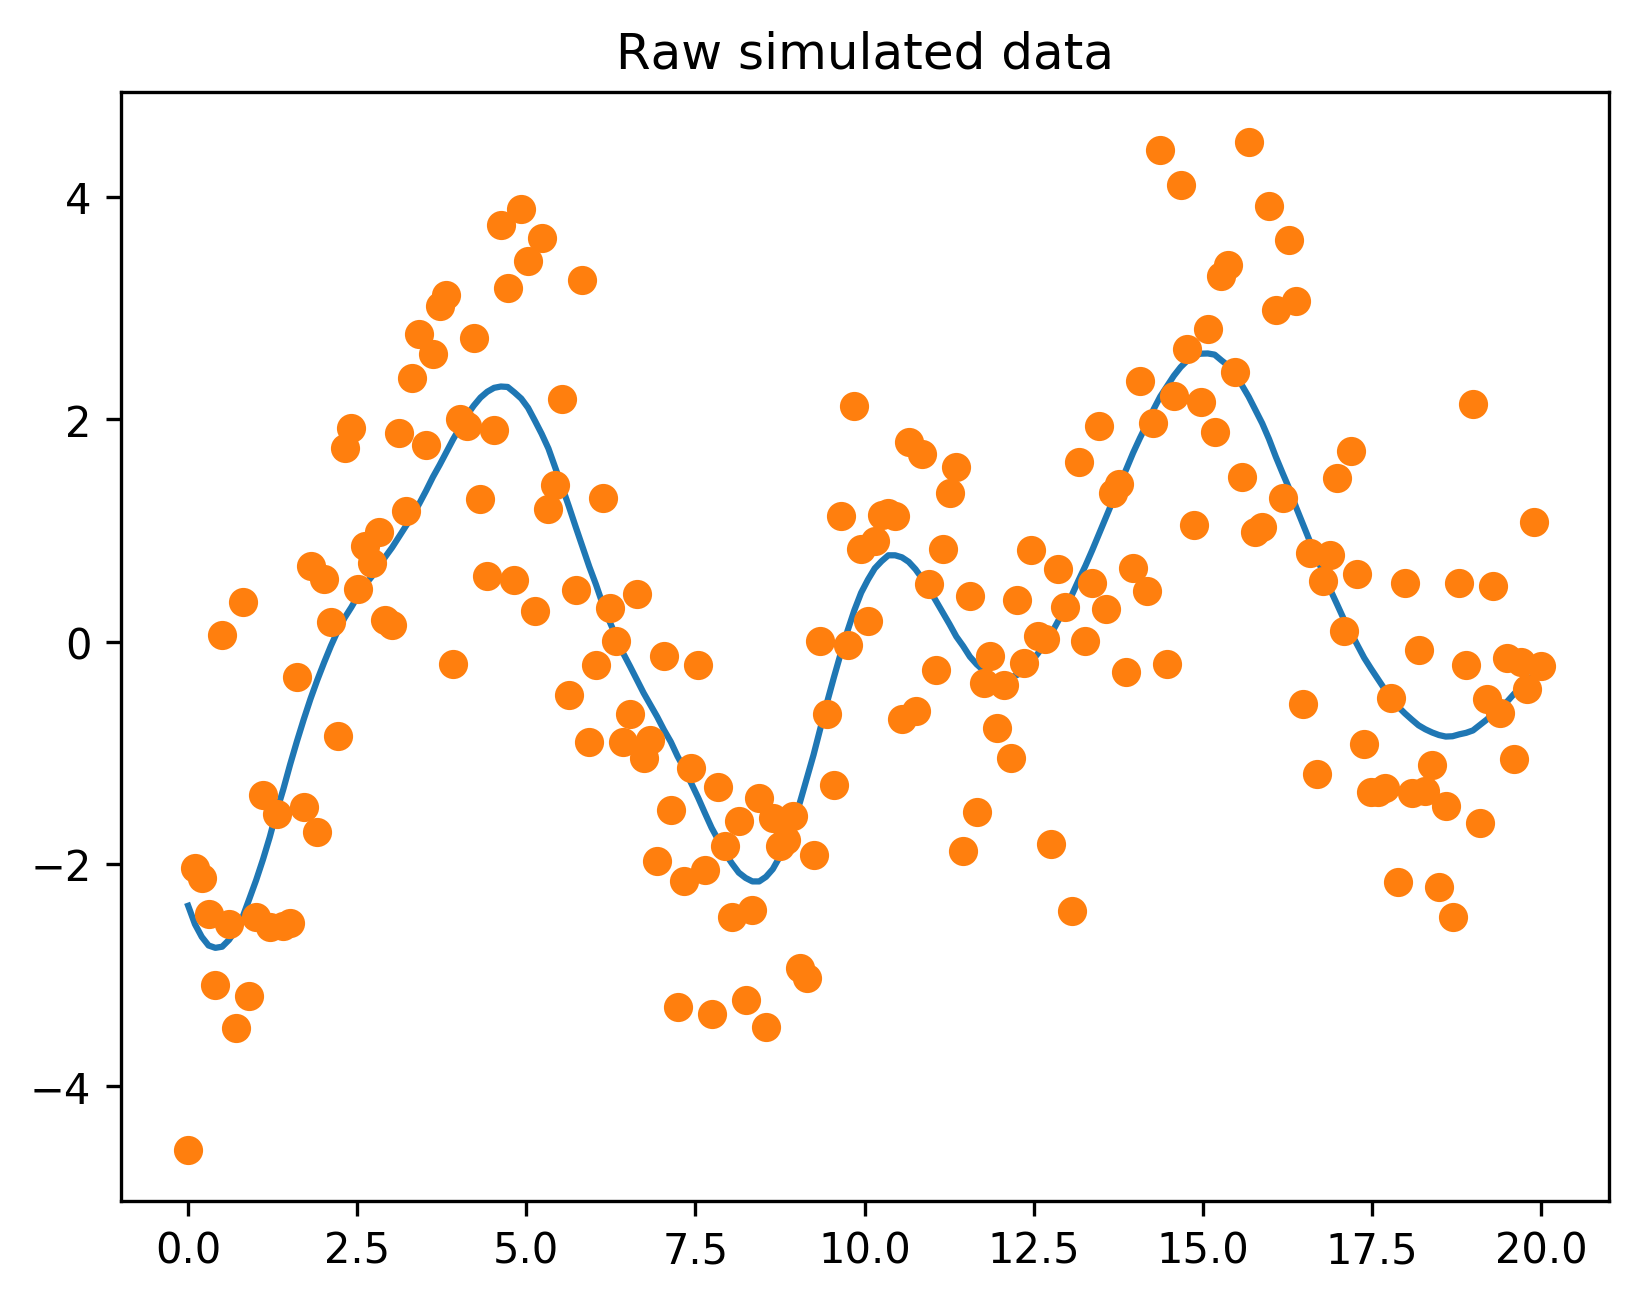

PyObject <matplotlib.text.Text object at 0x12f9a8ef0>

In [104]:
plt.plot(vec(X), Y_nonoise)
plt.plot(vec(X), Y, "o")
plt.title("Raw simulated data")

# Extrapolating behavior: plots

In [121]:
function plot_prediction(x, pred, color, label)
    y = pred[1]
    y_err = sqrt.(diag(pred[2]))
    plt.plot(x, y, label=label, color=color)
    plt.fill_between(x, y-2*y_err, y+2*y_err, color=color, alpha=0.2)
end

plot_prediction (generic function with 1 method)

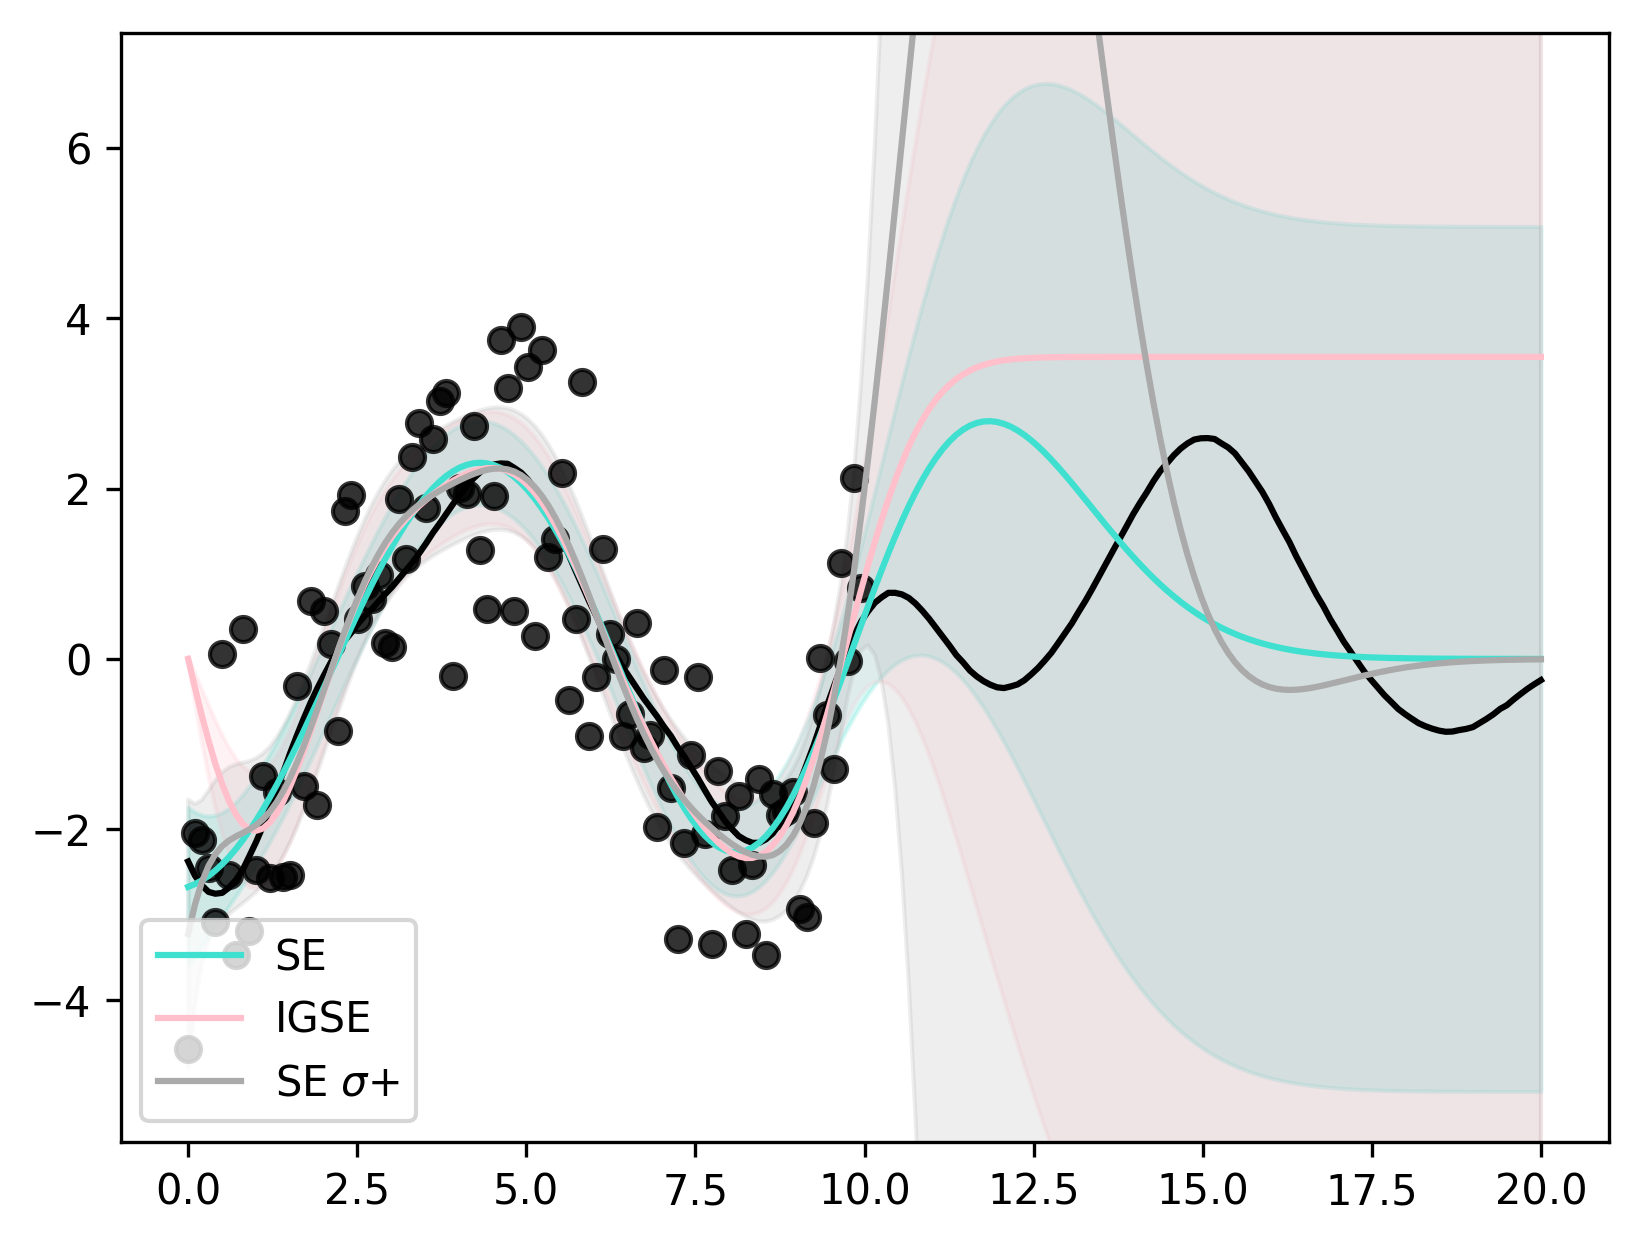

PyObject <matplotlib.legend.Legend object at 0x1319c75f8>

In [123]:
train = vec(X) .< 10
se = SEIso(0.0, 0.0)
igse = integse.IntegSE(se)
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GPE(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_target_and_dtarget!(se_fit)
optimize!(se_fit; method=Optim.ConjugateGradient())
igse_fit = GPE(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_target_and_dtarget!(igse_fit)
optimize!(igse_fit; method=Optim.ConjugateGradient())

se_σplus = SEIso(get_params(se)[1], log(100))
se_σplus_fit = GPE(X[:,train], Y[train], MeanZero(), se_σplus, se_fit.logNoise)

se_pred = predict_f(se_fit, X; full_cov=true)
igse_pred = predict_f(igse_fit, X; full_cov=true)
se_σplus_pred = predict_f(se_σplus_fit, X; full_cov=true)
plot_prediction(vec(X), se_pred, "turquoise", "SE")
_ylim = plt.ylim()
plot_prediction(vec(X), igse_pred, "pink", "IGSE")
plot_prediction(vec(X), se_σplus_pred, "#AAAAAA", L"SE $\sigma$+")
plt.ylim(_ylim)

plt.legend(loc="lower left")

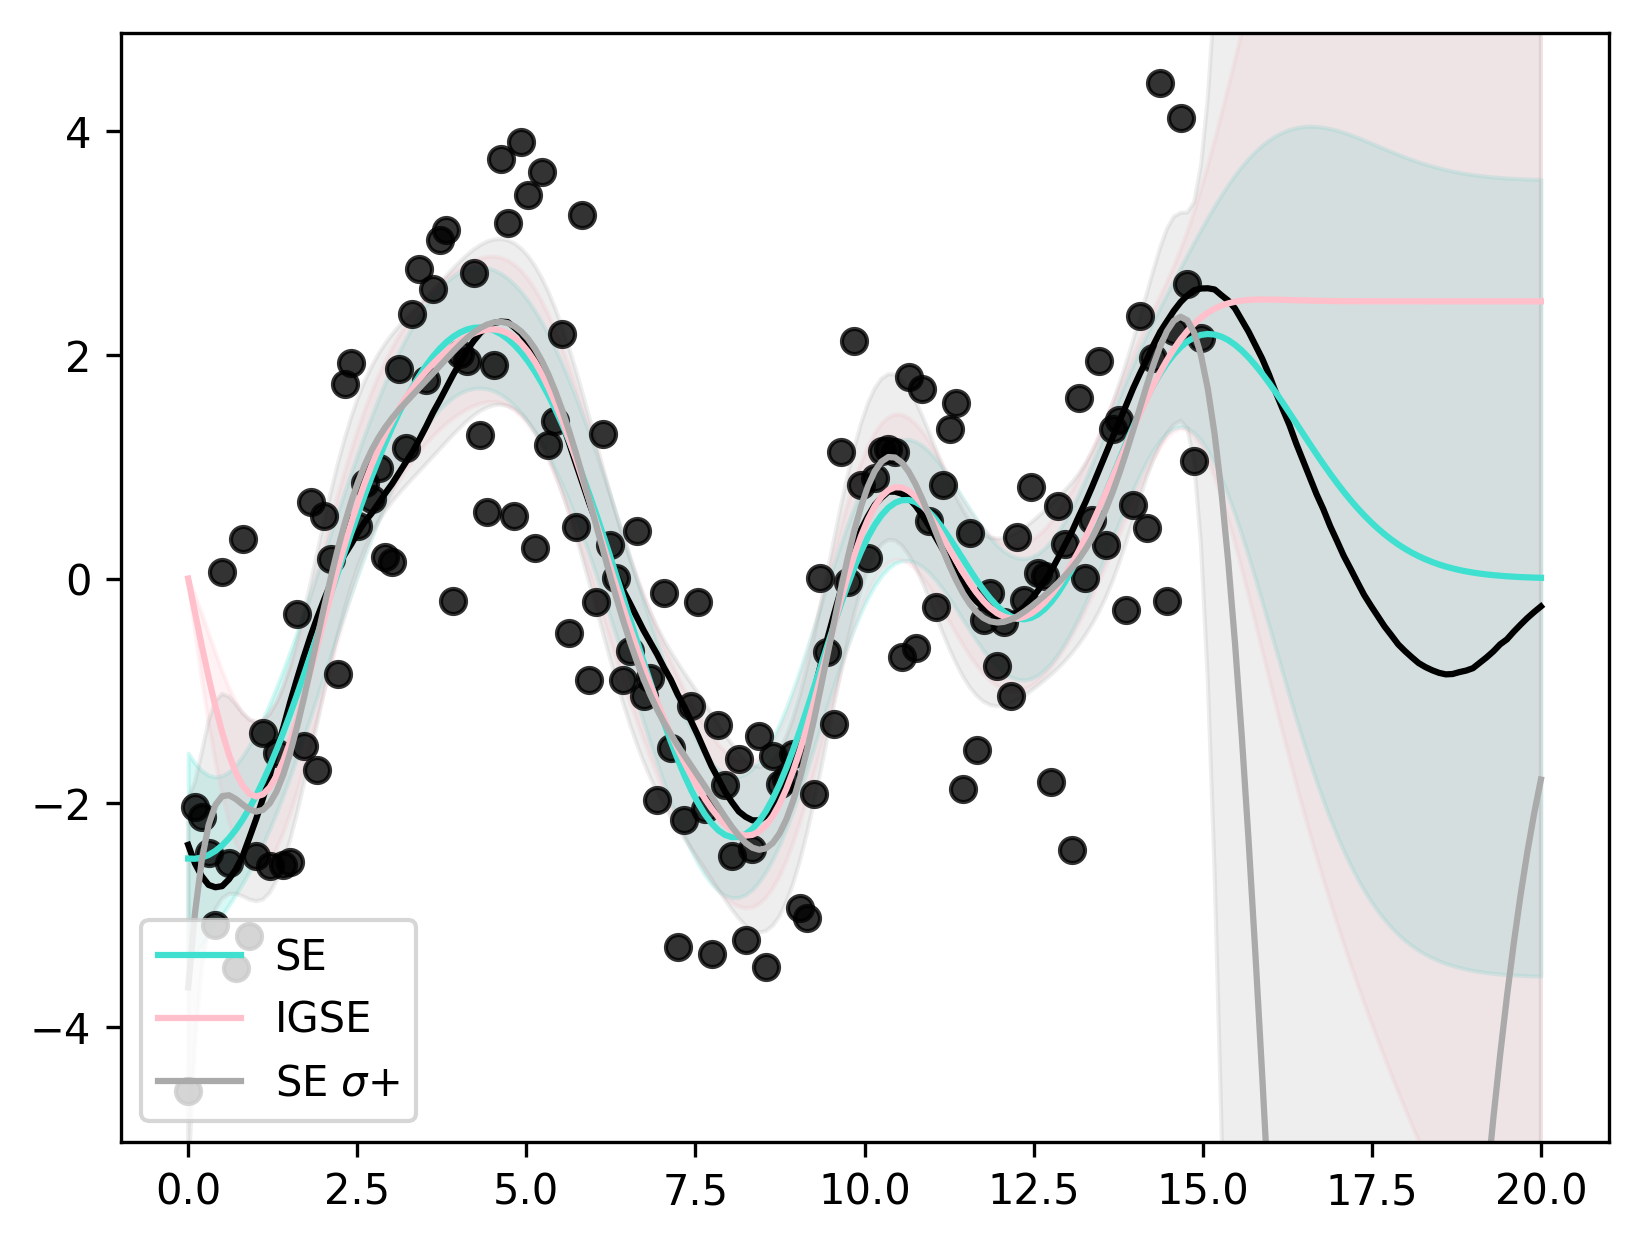

PyObject <matplotlib.legend.Legend object at 0x137d9ebe0>

In [124]:
train = vec(X) .< 15
se = SEIso(0.0, 0.0)
igse = integse.IntegSE(se)
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GPE(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_target_and_dtarget!(se_fit)
optimize!(se_fit; method=Optim.ConjugateGradient())
igse_fit = GPE(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_target_and_dtarget!(igse_fit)
optimize!(igse_fit; method=Optim.ConjugateGradient())

se_σplus = SEIso(get_params(se)[1], log(100))
se_σplus_fit = GPE(X[:,train], Y[train], MeanZero(), se_σplus, se_fit.logNoise)

se_pred = predict_f(se_fit, X; full_cov=true)
igse_pred = predict_f(igse_fit, X; full_cov=true)
se_σplus_pred = predict_f(se_σplus_fit, X; full_cov=true)
plot_prediction(vec(X), se_pred, "turquoise", "SE")
_ylim = plt.ylim()
plot_prediction(vec(X), igse_pred, "pink", "IGSE")
plot_prediction(vec(X), se_σplus_pred, "#AAAAAA", L"SE $\sigma$+")
plt.ylim(_ylim)

plt.legend(loc="lower left")

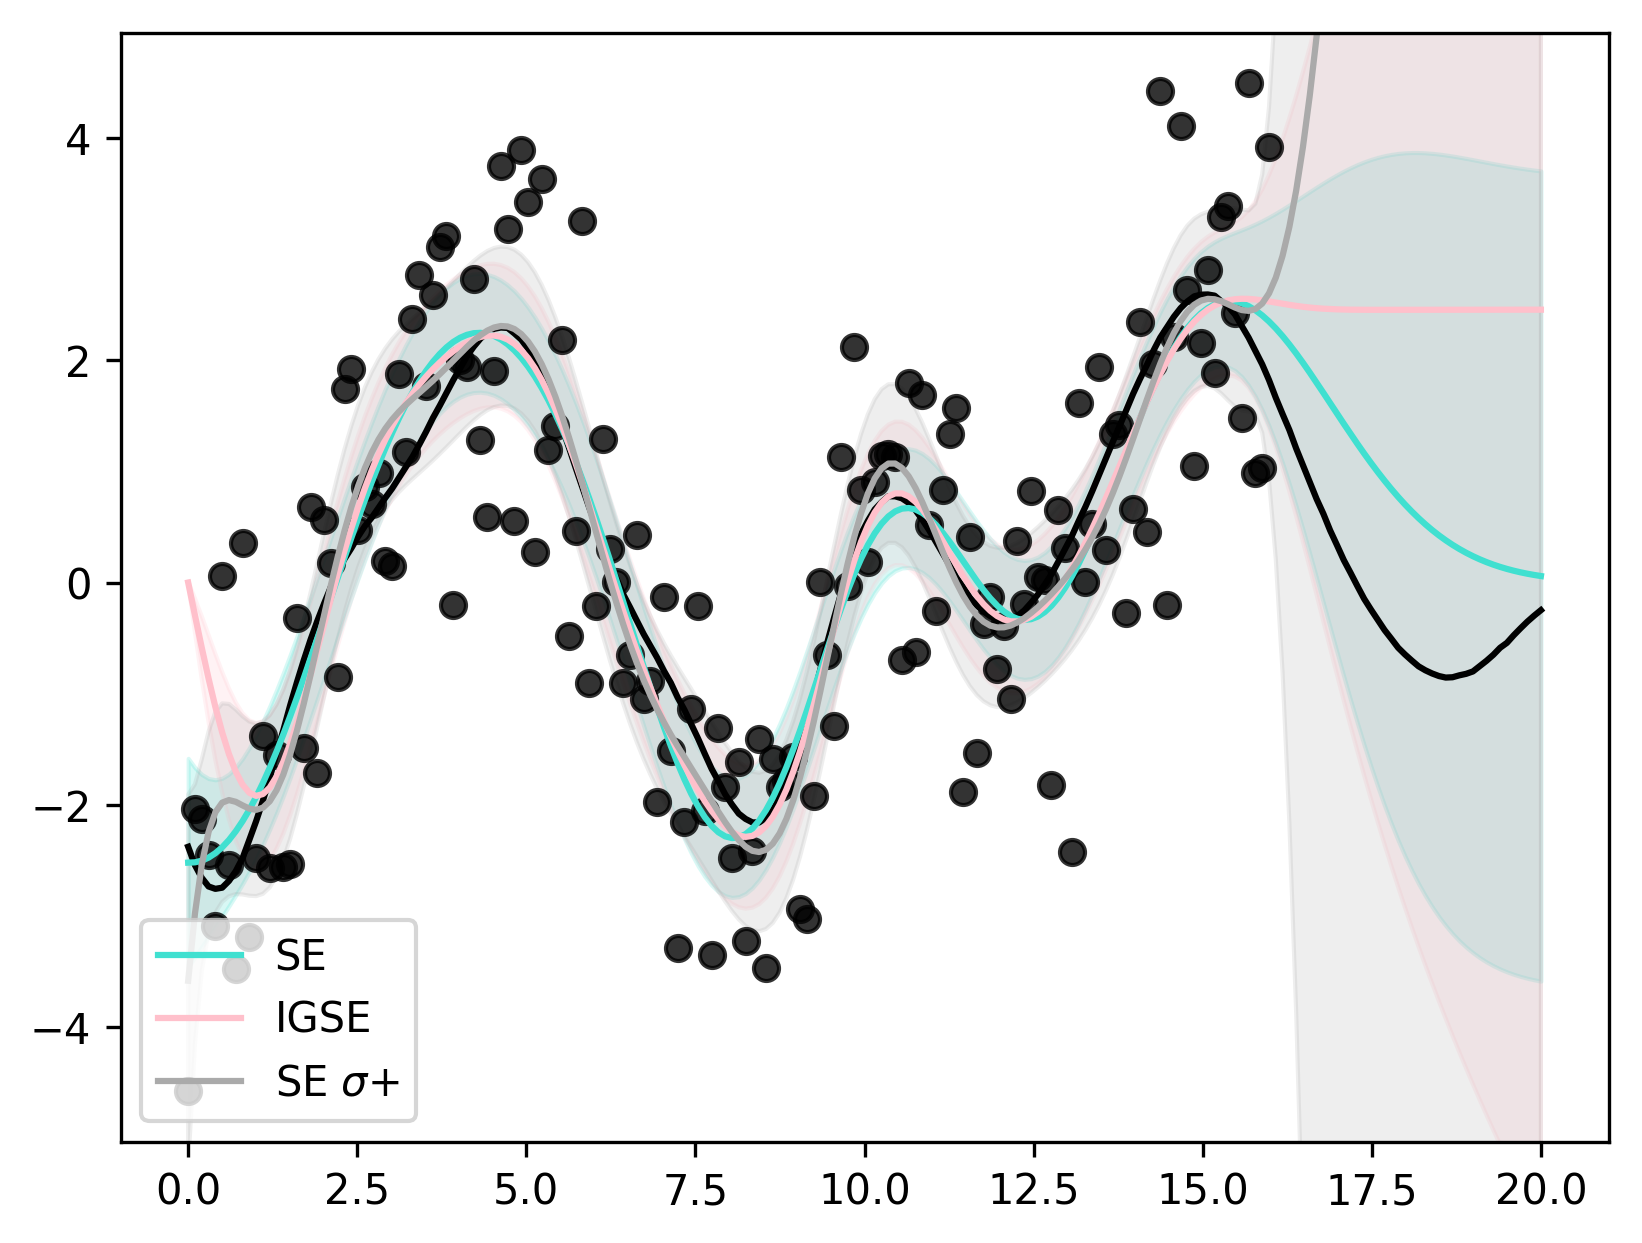

PyObject <matplotlib.legend.Legend object at 0x13196d898>

In [125]:
train = vec(X) .< 16
se = SEIso(0.0, 0.0)
igse = integse.IntegSE(se)
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GPE(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_target_and_dtarget!(se_fit)
optimize!(se_fit; method=Optim.ConjugateGradient())
igse_fit = GPE(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_target_and_dtarget!(igse_fit)
optimize!(igse_fit; method=Optim.ConjugateGradient())

se_σplus = SEIso(get_params(se)[1], log(100))
se_σplus_fit = GPE(X[:,train], Y[train], MeanZero(), se_σplus, se_fit.logNoise)

se_pred = predict_f(se_fit, X; full_cov=true)
igse_pred = predict_f(igse_fit, X; full_cov=true)
se_σplus_pred = predict_f(se_σplus_fit, X; full_cov=true)
plot_prediction(vec(X), se_pred, "turquoise", "SE")
_ylim = plt.ylim()
plot_prediction(vec(X), igse_pred, "pink", "IGSE")
plot_prediction(vec(X), se_σplus_pred, "#AAAAAA", L"SE $\sigma$+")
plt.ylim(_ylim)

plt.legend(loc="lower left")